# Using FastAI for creating a Waste Classifier

Fastai is a deep learning library which provides high-level components that can quickly and easily provide state-of-the-art results in standard deep learning domains. 

It has two main design goals: 
1. To be approachable and rapidly productive
2. To be also configurable. 

## Waste Classifier
The aim is to build a model for waste classification that identifies among the different classes: 
- cardboard
- compost
- glass
- metal
- paper
- plastic
- trash

This machine learning model will help people to improve their decision when classifying trash   

## Imports

In [1]:
from fastai.vision.all import *
from fastai.metrics import error_rate, accuracy

from fastai.vision.data import ImageDataLoaders

import warnings
warnings.filterwarnings('ignore')

from os import listdir
!pip install mlxtend
import matplotlib.pyplot as plt
from mlxtend.plotting import plot_confusion_matrix
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score


## Load the data

The data is already splitted in train and test folders. Inside each folder contains one folder for each class. Those images were obtained using Bing searcher using the api HTTP.   
Those images have been manually cleaned, removing the ones that were not useful or were in the wrong category. 
The data has been divided into two sets train and test sets.  

In [2]:
BASE_DIR = "/Users/mika/Projects/fastai-waste-classifier"
DATASET_DIR = f"{BASE_DIR}/dataset_splits"
TEST_PHOTOS_DIR = f"{BASE_DIR}/test-photos"

In [3]:
!ls $DATASET_DIR

test  train


In [4]:
!ls $DATASET_DIR/train/glass

11.jpeg           glass19.jpg       glass712.png      glass745.jpg
13.jpeg           glass20.jpg       glass714.jpeg     glass746.jpg
14.jpeg           glass215.jpg      glass715.jpg      glass747.jpg
16.jpeg           glass216.jpg      glass716.jpg      glass748.jpg
17.jpeg           glass22.jpg       glass72.jpg       glass749.jpg
2.jpeg            glass239.jpg      glass721.jpg      glass750.jpeg
21.jpeg           glass240.jpg      glass722.jpg      glass751.png
22.jpeg           glass241.jpg      glass723.jpg      glass752.jpg
23.jpeg           glass242.jpg      glass724.jpg      glass754.jpeg
24.jpeg           glass243.jpg      glass725.png      glass755.jpg
4.jpeg            glass25.jpg       glass726.jpg      glass757.jpg
5.jpeg            glass26.jpg       glass728.jpeg     glass758.jpg
6.jpeg            glass29.jpg       glass729.jpg      glass759.jpg
7.jpeg            glass32.jpg       glass730.jpeg     glass760.jpg
9.jpeg            glass33.jpg       glass731.jpg      glass7

## Data augmentation

Apply data augmentation to the training data, keeping 10% the for validation set. Data augmentation process apply some transformations (flip, rotate) to the original images to generate more data to train the model. Plus, helps to avoid overfitting, making the training set less specific. 

The validation set is used to track the model error while training. 


In [5]:
data = ImageDataLoaders.from_folder(
    DATASET_DIR,
    train ='train',
    shuffle=True,
    valid_pct=0.1,
    item_tfms =[ToTensor,RandomResizedCrop(224, min_scale=0.35)],
    batch_tfms=aug_transforms(flip_vert=True, batch=True, max_rotate=30.0),
)

Let's show some of the data for the validation and training sets.

In [6]:
data.valid_ds.items[:3]

[Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/paper/paper315.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/compost/compost738.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/test/compost/compost267.jpg')]

In [7]:
data.train_ds.items[:3]

[Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/paper/paper50.jpg'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/train/trash/metal213.JPG'),
 Path('/Users/mika/Projects/fastai-waste-classifier/dataset_splits/test/cardboard/cardboard214.jpg')]

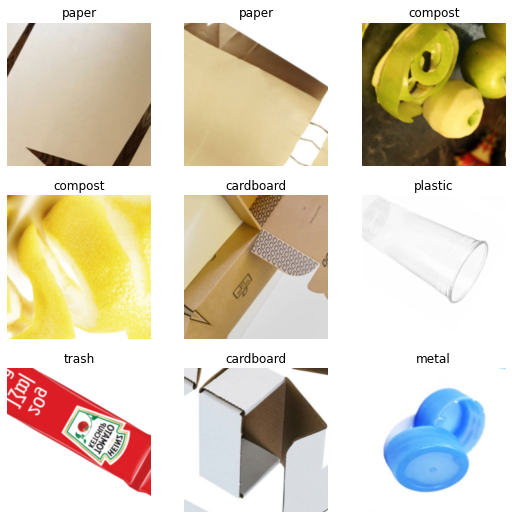

In [8]:
data.train.show_batch()

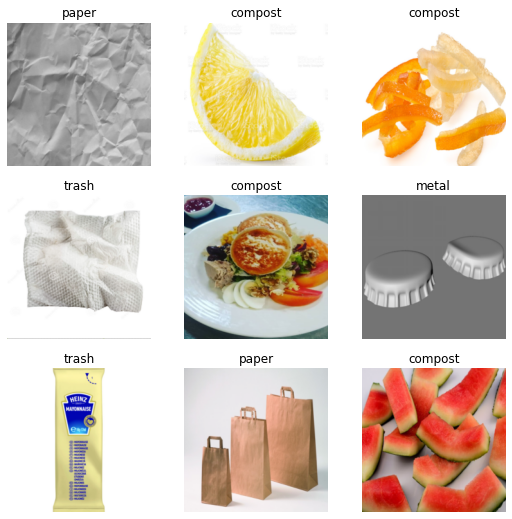

In [9]:
data.valid.show_batch()

In [10]:
data.vocab

['cardboard', 'compost', 'glass', 'metal', 'paper', 'plastic', 'trash']

## Training the model using resnet50

ResNet34 is a convolutional neural network(CNN) that has 34 layers. It has been already trained with images from the ImageNet database. It classifies 1000 object from very broad categories, such as pencil or animals. The input size of the network is 224x224. 

This network can be reused to train other model. 

In [11]:
learn = cnn_learner(data, resnet50, metrics=accuracy)
learn.fine_tune(20)
learn.export(fname=f'{BASE_DIR}/result-resnet34.pkl')

epoch,train_loss,valid_loss,accuracy,time
0,1.213260,0.384657,0.881188,12:59


epoch,train_loss,valid_loss,accuracy,time
0,0.640951,0.278979,0.900990,18:01
1,0.509911,0.226677,0.924092,19:40
2,0.403123,0.248153,0.937294,19:35
3,0.341892,0.335595,0.904290,17:49
4,0.306688,0.481955,0.894389,18:46
5,0.293516,0.321525,0.907591,18:21
6,0.252876,0.262408,0.920792,18:31
7,0.210513,0.279133,0.920792,16:13
8,0.183848,0.209897,0.940594,16:51
9,0.171032,0.375393,0.910891,16:14


## Metrics
Now, let's calculate the accuracy metric for the test set. 
The test set refers to a group of data that has been separated form the training data and the model does not know. 
It contains original images without any transformation. It will reflect how well the model will behave in the real life, when classifying new images.

Let's see what is the result for some photos that we took with the cellphone and check what is the output of the model. 

In [12]:
import utils 

We can see that has good accuracy, so we decided to use this model for our final solution

Accuracy 0.9885433715220949
F1 score 0.9902526896236807
              precision    recall  f1-score   support

   cardboard       0.99      1.00      0.99        80
     compost       1.00      1.00      1.00       154
       glass       1.00      1.00      1.00        25
       metal       0.97      1.00      0.98        57
       paper       0.99      0.96      0.98       114
     plastic       1.00      1.00      1.00        48
       trash       0.98      0.98      0.98       133

    accuracy                           0.99       611
   macro avg       0.99      0.99      0.99       611
weighted avg       0.99      0.99      0.99       611



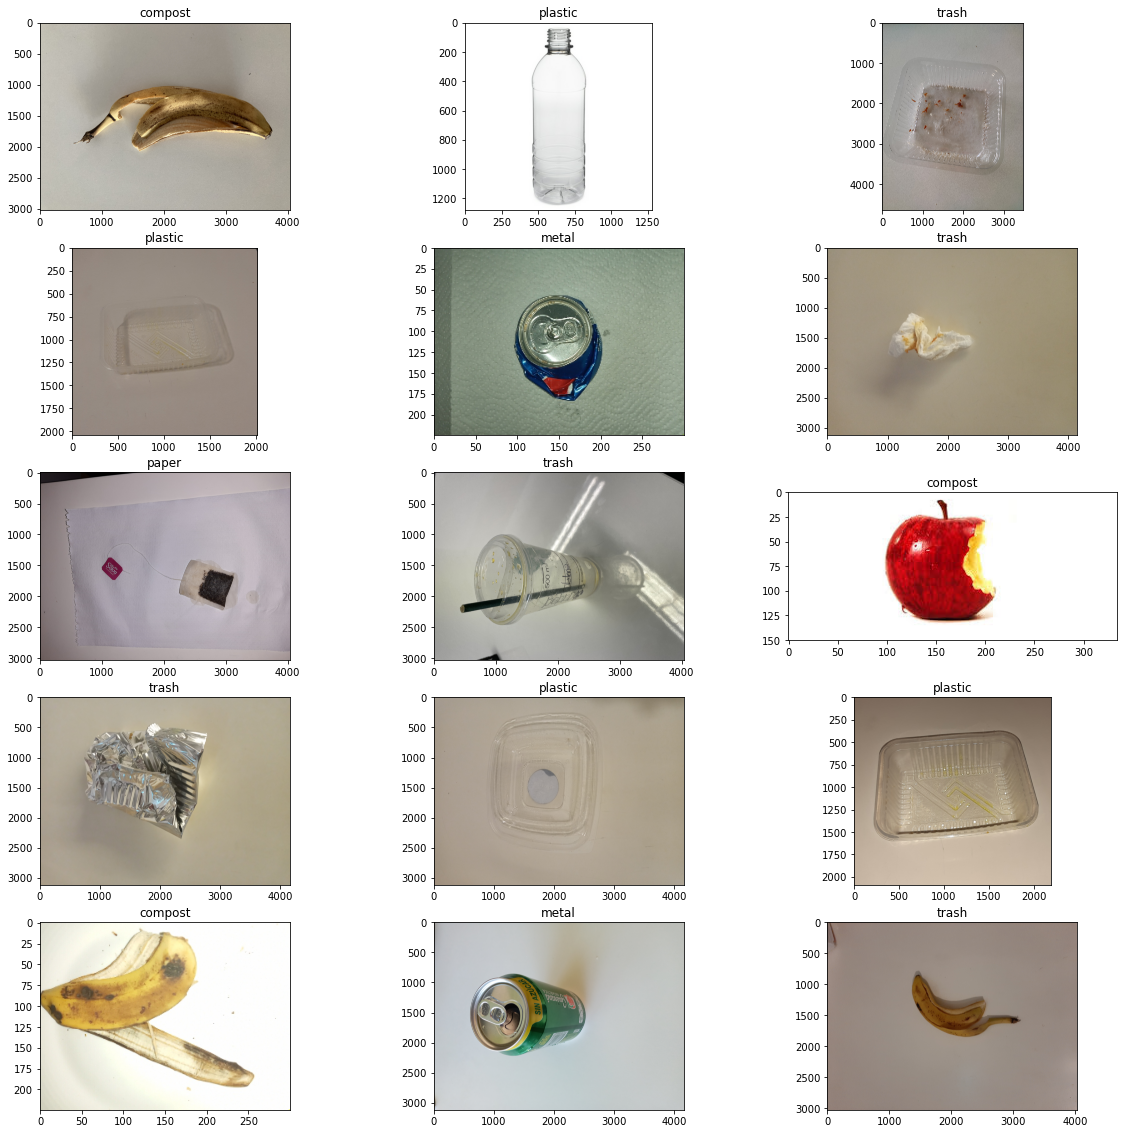

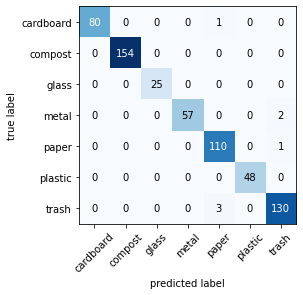

In [13]:
learn_loaded = load_learner(f'{BASE_DIR}/result-resnet34.pkl')
utils.show_predictions(learn_loaded, TEST_PHOTOS_DIR)                      
utils.print_results(data.vocab, learn_loaded, f"{DATASET_DIR}/test", 'classification_matrix_resnet34.png')